# Advancing Chemical Safety Prediction: An Integrated GNN Framework with DFT-augmented Cyclic Compound Solution

- This code implements a Random Forest regression model for predicting HoC values of cyclic compounds using RDKit-derived molecular descriptors.
- The model is trained on an RDKit-based feature set including physicochemical properties (ExactMolWt, TPSA, HBA, HBD), topological indices (Kappa1, BertzCT, Chi1, BalabanJ), and composition-based features such as the oxygen atom count.
- Note: Only hand-crafted RDKit descriptors are used as input features in this version; no learned graph embeddings or additional external features are concatenated.

### Preprocessing
- SMILES strings directly converted to RDKit Mol objects 
- RDKit-derived molecular descriptors generated (e.g., ExactMolWt, TPSA, HBA, HBD, Kappa1, BertzCT, Chi1, BalabanJ, oxygen atom count)
- Dataset split into train/test: 80/20 with random_state = 41
- Target: experimental HoC values (kJ/mol), unscaled
- No additional feature scaling or normalization applied

### Model Selection and Hyperparameter Tuning
- Base model: Random Forest regressor
- K-fold cross-validation on the training set performed prior to hyperparameter tuning (random_state = 41)
- Grid search over the Random Forest hyperparameters (e.g., n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf)
- Final model selected based on the lowest cross-validated error on the training data

## 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Descriptors 

from rdkit.Chem.Descriptors import ExactMolWt, TPSA
from rdkit.Chem.GraphDescriptors import BalabanJ, BertzCT, Chi0, Chi1, Kappa1
from rdkit.Chem.rdMolDescriptors import CalcTPSA, CalcExactMolWt, CalcNumHBA, CalcNumHBD, CalcWHIM, CalcLabuteASA
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem import MolSurf

from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import GetDistanceMatrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
import warnings
#import lazypredict
warnings.filterwarnings("ignore")

## 1. Data Loading
### 1-1. Exploring Data Structure

In [3]:
df = pd.read_csv('HoC_total_data_50.csv', keep_default_na=False)
df

,num,SMILES,HoC
0,1,C1CC1C2CC2,-3.88610
1,2,C2CC(C1CCC1)C2,-5.03520
2,3,C2CCC(C1CCCC1)C2,-6.32826
3,4,C2CCC(C1CCCCC1)CC2,-7.58990
4,5,C2CCCC(C1CCCCCC1)CC2,-8.94000
5,6,C2CCCC(C1CCCCCCC1)CCC2,-10.32830
6,7,C2CCCCC(C1CCCCCCCC1)CCC2,-11.65090
7,8,C2CCCCC(C1CCCCCCCCC1)CCCC2,-12.97690
8,9,C2CCCCCC(C1CCCCCCCCCC1)CCCC2,-14.29850
9,10,C2CCCCCC(C1CCCCCCCCCCC1)CCCCC2,-15.62040


### 1-2. Convert SMILES to RDKit Mol Objects

In [4]:
for i in range(len(df)) :
    df['Mol'] = 0
for i in range(len(df)) :
    df['Mol'][i] = Chem.MolFromSmiles(df['SMILES'][i])

df.head(5)

,num,SMILES,HoC,Mol
0,1,C1CC1C2CC2,-3.88610,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...
1,2,C2CC(C1CCC1)C2,-5.03520,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...
2,3,C2CCC(C1CCCC1)C2,-6.32826,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...
3,4,C2CCC(C1CCCCC1)CC2,-7.58990,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...
4,5,C2CCCC(C1CCCCCC1)CC2,-8.94000,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...


### 1-3. Generate Molecular Features

In [5]:
list_Mol = df['Mol']
MolWt =[] 
for mol in list_Mol:
    try :
        MolWt.append(CalcExactMolWt(Chem.AddHs(mol)))

    except :
        MolWt.append(0)
        continue

df['MolWt'] = MolWt
display(MolWt.count(0))
display(df.head())

0

,num,SMILES,HoC,Mol,MolWt
0,1,C1CC1C2CC2,-3.88610,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,82.078250
1,2,C2CC(C1CCC1)C2,-5.03520,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,110.109550
2,3,C2CCC(C1CCCC1)C2,-6.32826,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,138.140851
3,4,C2CCC(C1CCCCC1)CC2,-7.58990,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,166.172151
4,5,C2CCCC(C1CCCCCC1)CC2,-8.94000,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,194.203451


In [6]:
tpsa =[] 
for mol in list_Mol:
    try :
        tpsa.append(CalcTPSA(Chem.AddHs(mol)))

    except :
        tpsa.append(0)
        continue

df['tpsa'] = tpsa
display(tpsa.count(0))
display(df.head(1))

31

,num,SMILES,HoC,Mol,MolWt,tpsa
0,1,C1CC1C2CC2,-3.8861,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,82.07825,0.0


In [7]:
HBA =[]
HBO =[]
for mol in list_Mol:
    try :
        HBA.append(CalcNumHBA(Chem.AddHs(mol)))
        HBO.append(CalcNumHBD(Chem.AddHs(mol)))
    except :
        HBA.append(0)
        HBO.append(0)
        continue

df['HBA'] = HBA
df['HBO'] = HBO

display(df.head(5))

,num,SMILES,HoC,Mol,MolWt,tpsa,HBA,HBO
0,1,C1CC1C2CC2,-3.88610,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,82.078250,0.0,0,0
1,2,C2CC(C1CCC1)C2,-5.03520,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,110.109550,0.0,0,0
2,3,C2CCC(C1CCCC1)C2,-6.32826,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,138.140851,0.0,0,0
3,4,C2CCC(C1CCCCC1)CC2,-7.58990,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,166.172151,0.0,0,0
4,5,C2CCCC(C1CCCCCC1)CC2,-8.94000,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,194.203451,0.0,0,0


In [8]:
Kappa=[]
for mol in list_Mol:
    try :
        Kappa.append(Kappa1(Chem.AddHs(mol)))

    except :
        Kappa.append(0)
        continue

df['Kappa'] = Kappa
display(Kappa.count(0))
display(df.head(1))

0

,num,SMILES,HoC,Mol,MolWt,tpsa,HBA,HBO,Kappa
0,1,C1CC1C2CC2,-3.8861,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,82.07825,0.0,0,0,0.519031


In [9]:
bertz_ct =[] 
for mol in list_Mol:
    try :
        bertz_ct.append(BertzCT(Chem.AddHs(mol)))

    except :
        bertz_ct.append(0)
        continue

df['bertz_ct'] = bertz_ct
display(bertz_ct.count(0))
display(df.head(1))

0

,num,SMILES,HoC,Mol,MolWt,tpsa,HBA,HBO,Kappa,bertz_ct
0,1,C1CC1C2CC2,-3.8861,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,82.07825,0.0,0,0,0.519031,303.505544


In [10]:
chi1 =[] 
for mol in list_Mol:
    try :
        chi1.append(Chi1(Chem.AddHs(mol)))

    except :
        chi1.append(0)
        continue

df['chi1'] = chi1
display(df.count(0))
display(df.head(1))

num         55
SMILES      55
HoC         55
Mol         55
MolWt       55
tpsa        55
HBA         55
HBO         55
Kappa       55
bertz_ct    55
chi1        55
dtype: int64

,num,SMILES,HoC,Mol,MolWt,tpsa,HBA,HBO,Kappa,bertz_ct,chi1
0,1,C1CC1C2CC2,-3.8861,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,82.07825,0.0,0,0,0.519031,303.505544,6.75


In [11]:
Balaban =[] 
for mol in list_Mol:
    try :
        Balaban.append(BalabanJ(Chem.AddHs(mol)))

    except :
        Balaban.append(0)
        continue

df['Balaban'] = Balaban
display(Balaban.count(0))
display(df.head(1))

0

,num,SMILES,HoC,Mol,MolWt,tpsa,HBA,HBO,Kappa,bertz_ct,chi1,Balaban
0,1,C1CC1C2CC2,-3.8861,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,82.07825,0.0,0,0,0.519031,303.505544,6.75,2.531069


In [12]:
df.head(5)

,num,SMILES,HoC,Mol,MolWt,tpsa,HBA,HBO,Kappa,bertz_ct,chi1,Balaban
0,1,C1CC1C2CC2,-3.88610,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,82.078250,0.0,0,0,0.519031,303.505544,6.75,2.531069
1,2,C2CC(C1CCC1)C2,-5.03520,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,110.109550,0.0,0,0,0.741021,444.960927,9.25,2.760859
2,3,C2CCC(C1CCCC1)C2,-6.32826,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,138.140851,0.0,0,0,0.963139,587.154878,11.75,3.112593
3,4,C2CCC(C1CCCCC1)CC2,-7.58990,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,166.172151,0.0,0,0,1.185306,744.315891,14.25,3.274569
4,5,C2CCCC(C1CCCCCC1)CC2,-8.94000,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,194.203451,0.0,0,0,1.407496,899.272049,16.75,3.509104


In [13]:
Os =[] 
for mol in list_Mol:
    try :
        numO = [atom.GetSymbol() for atom in mol.GetAtoms()].count('O')
        Os.append(numO)
    except :
        Os.append(0)
        continue

df['Os'] = Os
display(Os.count(0))
display(df.head(1))

43

,num,SMILES,HoC,Mol,MolWt,tpsa,HBA,HBO,Kappa,bertz_ct,chi1,Balaban,Os
0,1,C1CC1C2CC2,-3.8861,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,82.07825,0.0,0,0,0.519031,303.505544,6.75,2.531069,0


### 1-4. Save Processed Dataset

In [14]:
df.to_csv('HoC_total_data_50_f.csv')

### 1-5. Load Processed Dataset

In [15]:
df1 = pd.read_csv('HoC_total_data_50_f.csv' , index_col = 0)
df1

,num,SMILES,HoC,Mol,MolWt,tpsa,HBA,HBO,Kappa,bertz_ct,chi1,Balaban,Os
0,1,C1CC1C2CC2,-3.88610,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,82.078250,0.00,0,0,0.519031,303.505544,6.750000,2.531069,0
1,2,C2CC(C1CCC1)C2,-5.03520,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,110.109550,0.00,0,0,0.741021,444.960927,9.250000,2.760859,0
2,3,C2CCC(C1CCCC1)C2,-6.32826,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,138.140851,0.00,0,0,0.963139,587.154878,11.750000,3.112593,0
3,4,C2CCC(C1CCCCC1)CC2,-7.58990,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,166.172151,0.00,0,0,1.185306,744.315891,14.250000,3.274569,0
4,5,C2CCCC(C1CCCCCC1)CC2,-8.94000,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,194.203451,0.00,0,0,1.407496,899.272049,16.750000,3.509104,0
5,6,C2CCCC(C1CCCCCCC1)CCC2,-10.32830,<rdkit.Chem.rdchem.Mol object at 0x00000179BA4...,222.234751,0.00,0,0,1.629697,1067.189932,19.250000,3.626355,0
6,7,C2CCCCC(C1CCCCCCCC1)CCC2,-11.65090,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,250.266051,0.00,0,0,1.851905,1231.446179,21.750000,3.794396,0
7,8,C2CCCCC(C1CCCCCCCCC1)CCCC2,-12.97690,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,278.297351,0.00,0,0,2.074117,1407.556833,24.250000,3.882782,0
8,9,C2CCCCCC(C1CCCCCCCCCC1)CCCC2,-14.29850,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,306.328651,0.00,0,0,2.296331,1579.135220,26.750000,4.009307,0
9,10,C2CCCCCC(C1CCCCCCCCCCC1)CCCCC2,-15.62040,<rdkit.Chem.rdchem.Mol object at 0x00000179BA3...,334.359951,0.00,0,0,2.518548,1761.865262,29.250000,4.078230,0


In [29]:
df1.HoC.plot.hist
plt.savefig('target_distribution')

<Figure size 640x480 with 0 Axes>

### 1-6 Splitting Data

In [17]:
X = df.iloc[:,4:14]
X

,MolWt,tpsa,HBA,HBO,Kappa,bertz_ct,chi1,Balaban,Os
0,82.078250,0.00,0,0,0.519031,303.505544,6.750000,2.531069,0
1,110.109550,0.00,0,0,0.741021,444.960927,9.250000,2.760859,0
2,138.140851,0.00,0,0,0.963139,587.154878,11.750000,3.112593,0
3,166.172151,0.00,0,0,1.185306,744.315891,14.250000,3.274569,0
4,194.203451,0.00,0,0,1.407496,899.272049,16.750000,3.509104,0
5,222.234751,0.00,0,0,1.629697,1067.189932,19.250000,3.626355,0
6,250.266051,0.00,0,0,1.851905,1231.446179,21.750000,3.794396,0
7,278.297351,0.00,0,0,2.074117,1407.556833,24.250000,3.882782,0
8,306.328651,0.00,0,0,2.296331,1579.135220,26.750000,4.009307,0
9,334.359951,0.00,0,0,2.518548,1761.865262,29.250000,4.078230,0


In [18]:
y = df['HoC']
y

0     -3.88610
1     -5.03520
2     -6.32826
3     -7.58990
4     -8.94000
5    -10.32830
6    -11.65090
7    -12.97690
8    -14.29850
9    -15.62040
10   -16.94390
11   -18.26870
12   -19.59220
13   -20.91230
14    -1.21720
15    -1.53360
16    -1.85210
17    -2.16940
18    -2.49940
19    -2.81210
20    -3.14340
21    -3.45870
22    -3.79540
23    -4.12240
24    -4.78930
25    -5.11160
26    -5.18290
27    -6.50270
28    -7.81340
29    -9.13210
30   -10.46740
31   -11.77850
32   -13.10840
33   -14.42390
34   -15.75630
35   -17.07620
36   -19.72630
37   -21.04520
38    -3.36600
39    -4.63562
40    -5.21900
41    -5.23874
42    -5.02100
43    -5.87388
44    -6.60460
45    -9.21530
46    -9.14540
47   -11.85030
48   -11.87460
49   -12.53330
50    -5.26570
51   -10.46600
52    -5.93140
53    -4.59700
54    -6.58620
Name: HoC, dtype: float64

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=41)

## 2. Fitting Random Forest model

In [20]:
#Before hyperparameter tuning 

from sklearn.ensemble import RandomForestRegressor 

lr = RandomForestRegressor ()

kfold = KFold(n_splits=5)

r2 = cross_val_score(lr, X_train, y_train, scoring='r2', cv = kfold)

print("R_scroe:",r2) 
# 5개로 split해서 

R_scroe: [0.88659384 0.83923408 0.94359604 0.39782752 0.85067609]


Accuracy of Model with Cross Validation is: 78.35855125904823 (+/- 0.20)


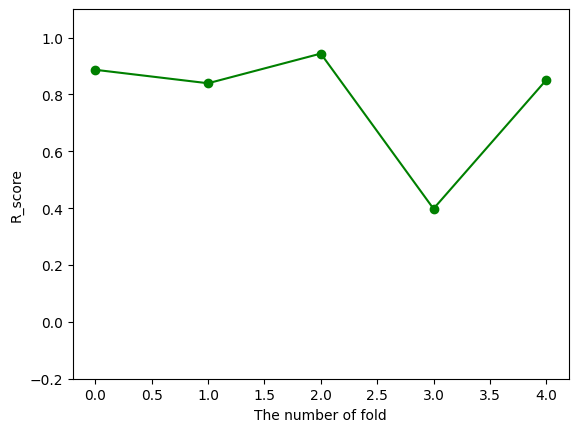

In [21]:
plt.plot(r2, '-g' 'o')
plt.ylim(-0.2, 1.1)
plt.xlabel('The number of fold')
plt.ylabel('R_score')
plt.show

#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",r2.mean() * 100, "(+/- %0.2f)" % r2.std())

### 2-1. Hyperparameters tuning

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


# Create the GridSearchCV object
rf = RandomForestRegressor()
#grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV object using the selected features and target variable
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and mean squared error
print("Best Hyperparameters: ", grid_search.best_params_)
print("mean_squred_error: ", grid_search.best_score_)
print("mean_squred_error: ", grid_search.best_score_)

Best Hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
mean_squred_error:  0.835077491158429
mean_squred_error:  0.835077491158429


### 2-2. Final Random Forest model fitting using the Best Hyperparameters

In [23]:
# Train a model with the best hyperparameters found by GridSearchCV
best_rf = RandomForestRegressor(max_depth=10, n_estimators=50, min_samples_split=2, min_samples_leaf=1)
best_rf.fit(X_train, y_train)

# Make predictions on the data
train_results = best_rf.predict(X_train)
test_results = best_rf.predict(X_test)

# Calculate the R-squared value
r2_1 = r2_score(train_results, y_train)
r2_2 = r2_score(test_results, y_test)

print('Train-R-squared:', r2_1)
print('Test-R-squared:', r2_2)

Train-R-squared: 0.9761284783563008
Test-R-squared: 0.9175348048613126


In [24]:
from sklearn.metrics import mean_absolute_error
m1 = mean_absolute_error(train_results, y_train)
m2 = mean_absolute_error(test_results, y_test)

print('Train_MAE:',m1)
print('Test_MAE:',m2)

Train_MAE: 0.3689527000000002
Test_MAE: 1.1489165090909106


### 2-3. Model Performance: Predicted vs Actual

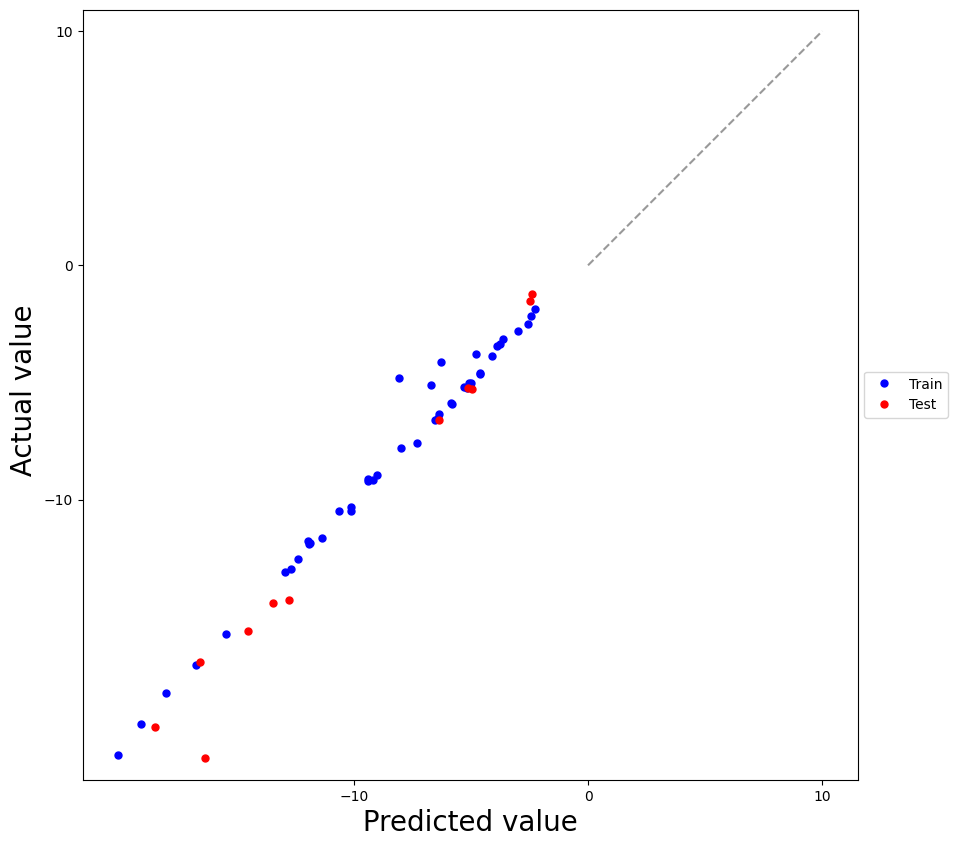

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.axis('equal')
ax.set_xticks(np.arange(-10,60,10))
ax.set_yticks(np.arange(-10,60,10))
ax.set_xlabel(' Predicted value ', fontsize=20)
ax.set_ylabel(' Actual value', fontsize=20)
ax.plot(train_results , y_train, '.', ms=10, label='Train', color = 'blue')
ax.plot(test_results ,y_test, '.',  ms=10, label='Test', color = 'red' )
ax.legend(loc='center left', bbox_to_anchor=(1, .5))
ax.plot([0,10], [0, 10], '--', color='.6')
plt.savefig('Hoc_randomforest50_linearity')

### 2-4. Feature Importance Analysis

In [26]:
feature_importances = best_rf.feature_importances_
feature_names = X_train.columns

sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importance = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

In [27]:
sorted_feature_names

Index(['Os', 'chi1', 'bertz_ct', 'MolWt', 'Kappa', 'Balaban', 'tpsa', 'HBO',
       'HBA'],
      dtype='object')

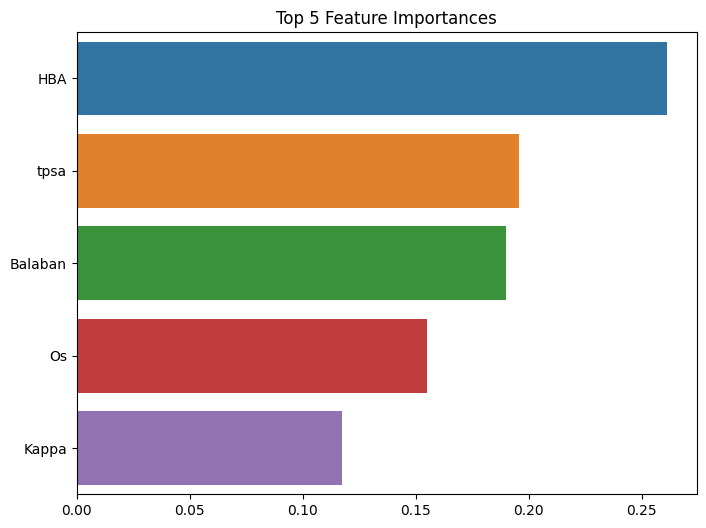

In [28]:
%matplotlib inline

ftr_importances_values = best_rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = sorted_feature_names)
ftr_top8 = ftr_importances.sort_values(ascending=False)[:5]

plt.figure(figsize=(8,6))
plt.title('Top 5 Feature Importances')
sns.barplot(x=ftr_top8, y=ftr_top8.index)
plt.savefig('feature importance')